# Digit Recognizer

Created by Zach Brazil, Richard Charles, Adam Kiehl, Zane Perkins

## Setup

In [1]:
# Import packages
import os
import glob
import shutil
import plotnine

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from plotnine import ggplot
from plotnine import aes 
from plotnine import geom_line
from plotnine import labs

In [2]:
# Reproducibility
np.random.seed(478)
tf.random.set_seed(478)

In [3]:
# Read in data from .csv files
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

# Convert Pandas dataframes to valid Numpy arrays
def convert(X):
    data = np.empty((X.shape[0], 28, 28, 1))
    for i in range(X.shape[0]):
        img = np.array(X.iloc[i, :]).reshape((28, 28, 1))
        data[i] = img
    return(np.array(data))

# Define training set
X_train = convert(train.drop('label', axis = 1))
y_train = train['label']

# Define testing set
X_test = convert(test)

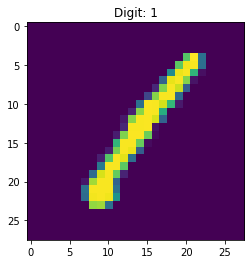

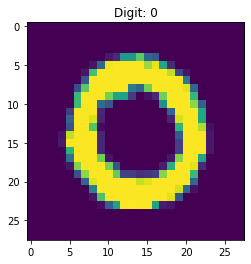

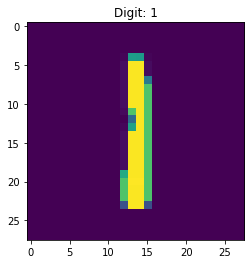

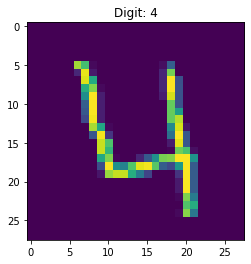

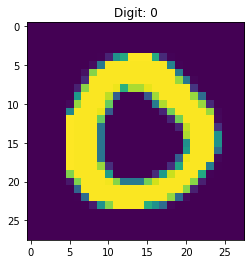

In [4]:
# Plot example digit images
for i in range(5):
    plt.imshow(X_train[i]) 
    plt.title(f"Digit: {y_train[i]}")
    plt.show() 

In [5]:
# Standardization function
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x):
    return (x - mean_px) / std_px

## Modeling

In [35]:
# Define model architecture
model = keras.Sequential([
    layers.Lambda(standardize, input_shape = (28, 28, 1)),
    layers.MaxPool2D(3),

    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),

    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),

    layers.DepthwiseConv2D(kernel_size = 3, depth_multiplier = 4, activation = 'relu'),
    layers.MaxPool2D(3),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(.1),
    layers.Dense(10, activation = 'softmax')
])

model.summary()

# Compile model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_12 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 9, 9, 1)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 32)          320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 5, 64)          18496     
_________________________________________________________________
depthwise_conv2d_11 (Depthwi (None, 3, 3, 256)         2560      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)             

In [26]:
# Define number of training epochs
EPOCHS = 10

# Train model with 75/25 training/validation split
trained = model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    validation_split = .25
)

Epoch 1/10
373/985 [==========>...................] - ETA: 3s - loss: 1.2298 - accuracy: 0.5959

_NotOkStatusException: InvalidArgumentError: Error while reading CompositeTensor._type_spec.

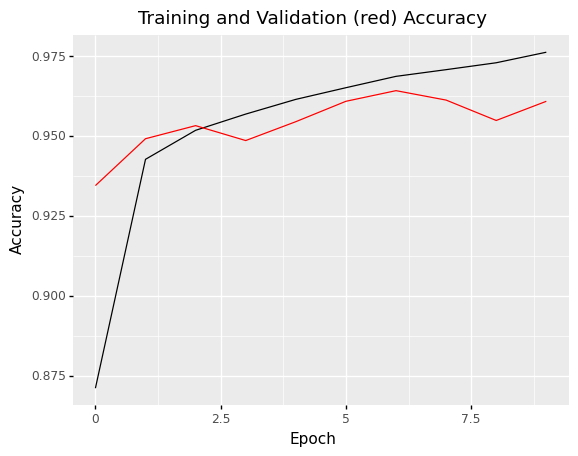

<ggplot: (8775482309648)>

In [19]:
# Plot training and validation accuracy
(
    ggplot() 
    + geom_line(aes(range(EPOCHS), trained.history['accuracy']))
    + geom_line(aes(range(EPOCHS), trained.history['val_accuracy']), color = 'red')
    + labs(title='Training and Validation (red) Accuracy', x='Epoch', y='Accuracy')
)

## Prediction

In [36]:
# Choose 5 epochs to avoid overfitting
EPOCHS = 5

# Retrain model on full training set
trained_full = model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    validation_split = 0
)

Epoch 1/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.8304 - accuracy: 0.7454
Epoch 2/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.2143 - accuracy: 0.9313
Epoch 3/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1725 - accuracy: 0.9454
Epoch 4/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1500 - accuracy: 0.9530
Epoch 5/5
1313/1313 [==============================] - 5s 4ms/step - loss: 0.1387 - accuracy: 0.9545


In [37]:
# Generate competition preedictions based on test set
pred = pd.DataFrame(model.predict(X_test)).idxmax(axis = 1)
submission = pd.DataFrame({'ImageId': range(1, len(pred) + 1), 'Label': pred})
submission.head()

# Write submission results to local .csv file
submission.to_csv('./Data/submission.csv', index=False)